In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:

tickers = 'NVDA'
data = yf.download(tickers, start="2020-01-01", end="2025-01-30")
data.tail()
start_date = '2020-01-01'

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
data['Gain/Loss'] = np.where(data['Close'] > data['Close'].shift(1), 'Gain', 'Loss')
data

Price,Close,High,Low,Open,Volume,Gain/Loss
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,
2020-01-02,5.972710,5.972710,5.893293,5.943831,237536000,Loss
2020-01-03,5.877111,5.920928,5.828067,5.852963,205384000,Loss
2020-01-06,5.901757,5.906985,5.757612,5.783752,262636000,Gain
2020-01-07,5.973209,6.019017,5.885079,5.930140,314856000,Gain
2020-01-08,5.984412,6.025739,5.928895,5.968976,277108000,Gain
...,...,...,...,...,...,...
2025-01-23,147.220001,147.229996,143.720001,145.050003,155915500,Gain
2025-01-24,142.619995,148.970001,141.880005,148.369995,234657600,Loss


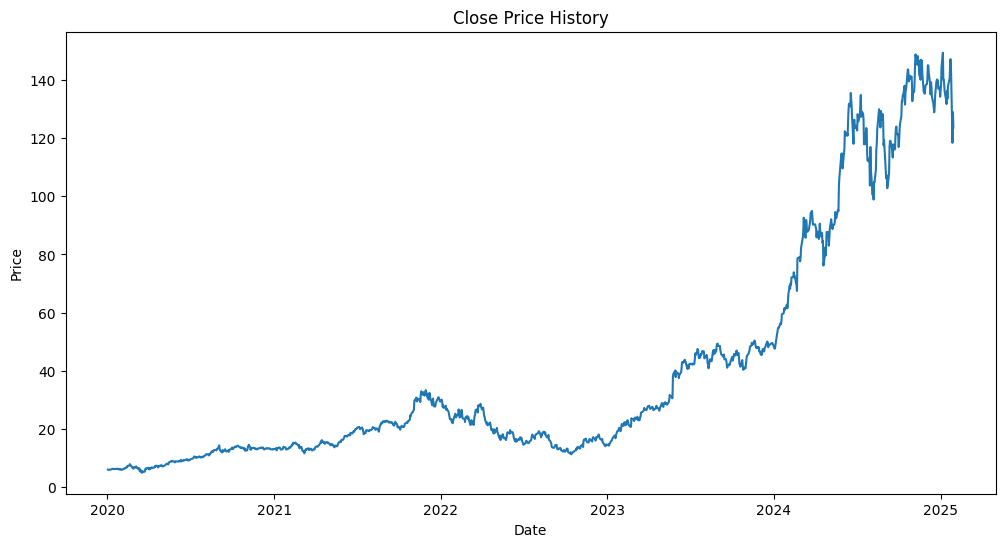

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price history')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
count,1276.000000,1276.000000,1276.000000,1276.000000,1.276000e+03
mean,39.839132,40.584049,39.031414,39.853898,4.445523e+08
std,39.721938,40.480411,38.936054,39.806701,1.883689e+08
min,4.892426,5.229715,4.500834,4.984596,9.788400e+07
25%,13.606187,13.875259,13.355802,13.711381,3.033396e+08
50%,21.700228,22.085736,21.105906,21.588797,4.181150e+08
75%,46.553779,47.073852,45.334108,46.467157,5.453080e+08
max,149.429993,153.130005,147.820007,153.029999,1.543911e+09


## Plots:

We currently have 2 plots that demonstrate:
- History/ average prices by sector
- Each sector's market share

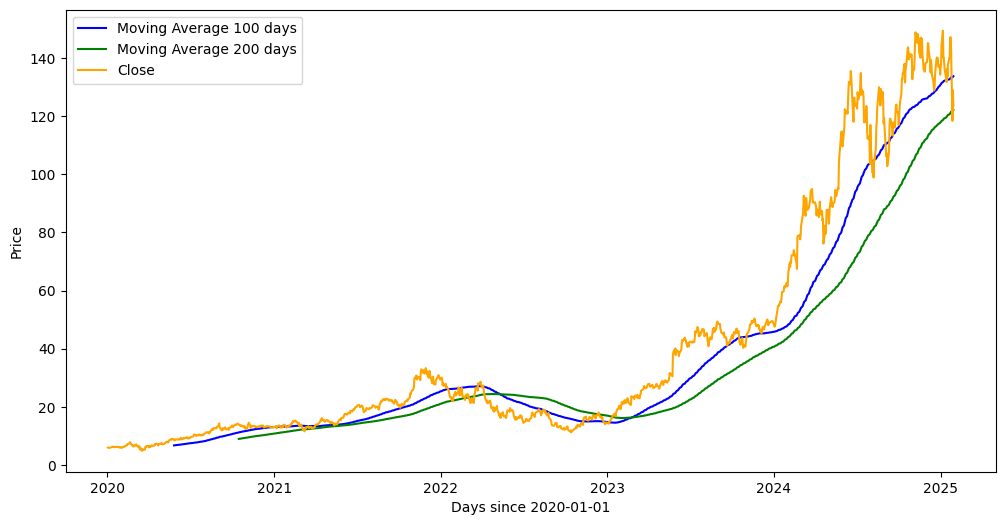

In [ ]:
# Plotting the data and the moving averages
avg1 = data['Close'].rolling(100).mean()
avg2 = data['Close'].rolling(200).mean()
plt.figure(figsize=(12,6))
plt.plot(avg1, 'blue', label='Moving Average 100 days')
plt.plot(avg2, 'green', label='Moving Average 200 days')
plt.plot(data['Close'], 'orange', label='Close')
plt.legend(loc='upper left')
plt.xlabel(f'Days since {start_date}')
plt.ylabel('Price')
plt.show()


Market Share Breakdown for 2024-02-26:       [M->Millions, B->Billions, T->Trillions]
Total Market Capitalization: $13.5T
Technology: $5.7T (42.19%)
Consumer Cyclical: $2.5T (18.52%)
Healthcare: $1.7T (12.71%)
Financial Services: $1.5T (11.29%)
Energy: $982.9B (7.26%)
Communication Services: $799.5B (5.90%)
Industrials: $289.7B (2.14%)


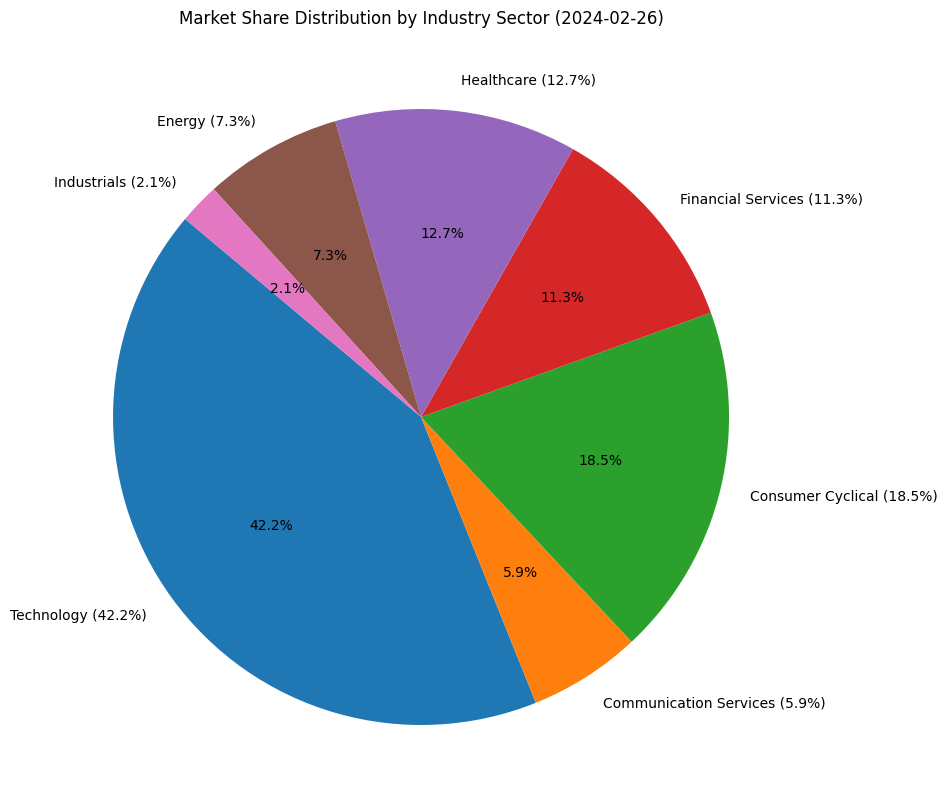


Returned Data: {'total_market_cap': np.float64(13546442221987.146), 'industry_market_caps': defaultdict(<class 'float'>, {'Technology': np.float64(5715303641639.1875), 'Communication Services': np.float64(799547411866.3594), 'Consumer Cyclical': np.float64(2508646067059.191), 'Financial Services': np.float64(1529203957578.4102), 'Healthcare': np.float64(1721137459151.974), 'Energy': np.float64(982897850562.1133), 'Industrials': np.float64(289705834129.9094)}), 'industry_percentages': {'Technology': np.float64(42.19044047124576), 'Communication Services': np.float64(5.902268645627255), 'Consumer Cyclical': np.float64(18.518855548561845), 'Financial Services': np.float64(11.288602073660114), 'Healthcare': np.float64(12.70545749907977), 'Energy': np.float64(7.255763797277915), 'Industrials': np.float64(2.138611964547338)}}


In [23]:
# Plotting 
from collections import defaultdict
from datetime import datetime, timedelta
def human_readable(num):
    """Converts large numbers to human-readable format (e.g., 1.2B, 32.5M)"""
    if num >= 1_000_000_000_000:
        return f"{num / 1_000_000_000_000:.1f}T"
    if num >= 1_000_000_000:
        return f"{num / 1_000_000_000:.1f}B"
    elif num >= 1_000_000:
        return f"{num / 1_000_000:.1f}M"
    else:
        return f"{num:,.2f}"

def plot_market_share_by_sector(date: str, tickers=None):
    """
    Generates a pie chart of market share distribution by industry sector for a given date
    and prints additional statistics in a human-readable format.

    Parameters:
        date (str): The target date in 'YYYY-MM-DD' format.
        tickers (list, optional): List of company tickers to analyze.
    
    Returns:
        dict: Contains sector market caps, total market cap, and percentage breakdown.
    """
    if tickers is None:
        tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',  # Tech
                   'JPM', 'V', 'BAC', 'WFC', 'GS',  # Finance
                   'JNJ', 'PFE', 'MRNA', 'UNH', 'LLY',  # Healthcare
                   'XOM', 'CVX', 'BP', 'COP', 'PSX',  # Energy
                   'UPS', 'FDX', 'CSX', 'NSC', 'DPZ']  # Shipping/Transport

    industry_data = defaultdict(float)
    
    # Convert string date to datetime and get the next day
    target_date = datetime.strptime(date, "%Y-%m-%d")
    next_day = target_date + timedelta(days=1)
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info
        industry = info.get('sector', 'Unknown')  # Get sector
        
        # Fetch historical price around the given date
        try:
            historical_data = stock.history(start=date, end=next_day.strftime("%Y-%m-%d"))
            
            if historical_data.empty:
                print(f"Skipping {ticker}: No data for {date}")
                continue
            
            close_price = historical_data['Close'].iloc[0]  # Closing price
            shares_outstanding = info.get('sharesOutstanding', 0)  # Number of shares
            
            market_cap = close_price * shares_outstanding  # Calculate market cap
            
            if market_cap > 0:
                industry_data[industry] += market_cap
        
        except Exception as e:
            print(f"Skipping {ticker}: Error fetching data - {e}")

    # If no valid data was retrieved, return
    if not industry_data:
        print("No valid market cap data found for the given date.")
        return
    
    # Calculate total market cap
    total_market_cap = sum(industry_data.values())

    # Generate percentage breakdown
    industry_percentages = {sector: (cap / total_market_cap) * 100 for sector, cap in industry_data.items()}
    
    # Print statistics with human-readable formatting
    print(f"\nMarket Share Breakdown for {date}:       [M->Millions, B->Billions, T->Trillions]")
    print(f"Total Market Capitalization: ${human_readable(total_market_cap)}")
    
    for sector, cap in sorted(industry_data.items(), key=lambda x: x[1], reverse=True):
        percentage = industry_percentages[sector]
        print(f"{sector}: ${human_readable(cap)} ({percentage:.2f}%)")

    # Extract labels and sizes for the pie chart
    labels = [f"{sector} ({percentage:.1f}%)" for sector, percentage in industry_percentages.items()]
    sizes = industry_data.values()

    # Create pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Market Share Distribution by Industry Sector ({date})")
    plt.show()
    
    return {
        "total_market_cap": total_market_cap,
        "industry_market_caps": industry_data,
        "industry_percentages": industry_percentages
    }

# Example usage:
stats = plot_market_share_by_sector("2024-02-26")

# Example of accessing returned data:
if stats:
    print("\nReturned Data:", stats)

## Central Motivation for project
 - Useable tool to help people navigate the stock market
 - See if there is a correlation between price movement in different sectors
 - Predict stock prices based off historical data 

## 2 Key Questions
- Is there a correlation between the performance of different sectors/industries?
- Can you reasonably predict stock price based only on past stock data?


In [20]:
tickers = ["AAPL", "GOOGL", "MSFT", "TSLA", "AMZN"]

data_list = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1mo")  
    hist["Ticker"] = ticker  
    stock_info = stock.info

    hist['Sector'] = stock_info.get('sector', 'None')
    hist['Industry'] = stock_info.get('industry', 'None')
    data_list.append(hist)

df = pd.concat(data_list)
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Sector,Industry
0,2025-01-22 00:00:00-05:00,219.548596,223.873842,219.548596,223.584167,64126500,0.0,0.0,AAPL,Technology,Consumer Electronics
1,2025-01-23 00:00:00-05:00,224.493183,226.780662,222.055861,223.414368,60234800,0.0,0.0,AAPL,Technology,Consumer Electronics
2,2025-01-24 00:00:00-05:00,224.533128,225.382200,221.166834,222.535324,54697900,0.0,0.0,AAPL,Technology,Consumer Electronics
3,2025-01-27 00:00:00-05:00,223.773962,231.895022,223.733997,229.607544,94863400,0.0,0.0,AAPL,Technology,Consumer Electronics
4,2025-01-28 00:00:00-05:00,230.596471,239.926210,230.556507,237.998322,75707600,0.0,0.0,AAPL,Technology,Consumer Electronics
...,...,...,...,...,...,...,...,...,...,...,...
105,2025-02-14 00:00:00-05:00,229.199997,229.889999,227.229996,228.679993,27031100,0.0,0.0,AMZN,Consumer Cyclical,Internet Retail
106,2025-02-18 00:00:00-05:00,228.820007,229.300003,223.720001,226.649994,42975100,0.0,0.0,AMZN,Consumer Cyclical,Internet Retail
107,2025-02-19 00:00:00-05:00,225.520004,226.830002,223.710007,226.630005,28566700,0.0,0.0,AMZN,Consumer Cyclical,Internet Retail
108,2025-02-20 00:00:00-05:00,224.779999,225.130005,221.809998,222.880005,30001700,0.0,0.0,AMZN,Consumer Cyclical,Internet Retail
